# More advanced ODE system solution

## Chemical kinetics modeling

In this study we will perform the integration of a simplified chemical mechanism of acetylene pyrolysis as provided in this [thesis](https://publikationen.bibliothek.kit.edu/1000007244/97488) by F. Graf, 2007. This mechanism is composed by 7 chemical species and the reaction rate equations are given in the table below. Although such simplified mechanism does not hold the thermodynamics of the system (because equations are not expressed in mass action kinetics formalism), it proves useful for CFD computation of chemically reacting flows since it largely reduces the number of equations to solve - a detailed acetylene pyrolysis mechanism has more than 200 chemical species, requiring integration of each of them in the simulated system. Such a detailed simulation would require the solution of mass, momentum, energy, and species simulations. Just a conventional CFD simulation can already prove difficult in computational terms, adding up species makes the problem exponentially more complex. The temperature dependent rate coefficient in these equations is given by $k(t)=A\exp\left(-\frac{E_a}{RT}\right)$, where the units of $A$ are such that the rate expression is given in moles per second, and $Ea$ is provided in $kJ$.

<table>
  <tr>
    <th style="width: 200px;">Reaction</th>
    <th style="width: 100px;">$A$</th>
    <th style="width: 100px;">$E_a$</th>
    <th style="width: 300px;">Rate</th>
  </tr>
  <tr>
    <td>$C_2H_2 + H_2 \rightarrow C_2H_4$</td>
    <td style="text-align: center;">4.4e+03</td>
    <td style="text-align: center;">1.0300e+05</td>
    <td>$r_{1}=k_{1}(T)[C_2H_2][H_2]^{0.36}$</td>
  </tr>
  <tr>
    <td>$C_2H_4 \rightarrow C_2H_2 + H_2$</td>
    <td style="text-align: center;">3.8e+07</td>
    <td style="text-align: center;">2.0000e+05</td>
    <td>$r_{2}=k_{2}(T)[C_2H_4]^{0.50}$</td>
  </tr>
  <tr>
    <td>$C_2H_2 + 3 H_2 \rightarrow 2 CH_4$</td>
    <td style="text-align: center;">1.4e+05</td>
    <td style="text-align: center;">1.5000e+05</td>
    <td>$r_{3}=k_{3}(T)[C_2H_2]^{0.35}[H_2]^{0.22}$</td>
  </tr>
  <tr>
    <td>$CH_4 + CH_4 \rightarrow C_2H_2 + 3 H_2$</td>
    <td style="text-align: center;">8.6e+06</td>
    <td style="text-align: center;">1.9500e+05</td>
    <td>$r_{4}=k_{4}(T)[CH_4]^0.21$</td>
  </tr>
  <tr>
    <td>$C_2H_2 \rightarrow 2 C(s) + H_2$</td>
    <td style="text-align: center;">5.5e+06</td>
    <td style="text-align: center;">1.6500e+05</td>
    <td>$r_{5}=k_{5}(T)\dfrac{[C_2H_2]^{1.90}}{1+18[H_2]}$</td>
  </tr>
  <tr>
    <td>$C_2H_2 + C_2H_2 \rightarrow C_4H_4$</td>
    <td style="text-align: center;">1.2e+05</td>
    <td style="text-align: center;">1.2070e+05</td>
    <td>$r_{6}=k_{6}(T)[C_2H_2]^{1.60}$</td>
  </tr>
  <tr>
    <td>$C_4H_4 \rightarrow C_2H_2 + C_2H_2$</td>
    <td style="text-align: center;">1.0e+15</td>
    <td style="text-align: center;">3.3520e+05</td>
    <td>$r_{7}=k_{7}(T)[C_4H_4]^{0.75}$</td>
  </tr>
  <tr>
    <td>$C_4H_4 + C_2H_2 \rightarrow C_6H_6$</td>
    <td style="text-align: center;">1.8e+03</td>
    <td style="text-align: center;">6.4500e+04</td>
    <td>$r_{8}=k_{8}(T)[C_2H_2]^{1.30}[C_4H_4]^{0.60}$</td>
  </tr>
  <tr>
    <td>$C_6H_6 \rightarrow 6 C(s) + 3 H_2$</td>
    <td style="text-align: center;">1.0e+03</td>
    <td style="text-align: center;">7.5000e+04</td>
    <td>$r_{9}=k_{9}(T)\dfrac{[C_2H_2]^{0.75}}{1+22[H_2]}$</td>
  </tr>
</table>

Generally, when dealing with chemical species, one writes the equations in terms of mass fractions. This is useful (and in many other applications) to easily evaluate mass balance. Rate equations are provided above are computed with concentrations, so if integrating mass fraction rates one must perform the conversion inside the rate expression, as provided below. The rate of generation/consumption of each species is given by the weighted sum of the rates of each equation where it appears multiplied by its stoichiometric coefficient in this reaction. For providing a general formulation, this is generally done with a matrix of stoichiometric coefficients often called $\nu$ (the Greek letter *nu*), where negative signs represent reacting species that are consumed and positive signs the generated products. Function `KineticsRhs` implements the species rates for this system as described above. Notice that for the porter gas $N_2$ that does not participate in reactions, we compute its rate as the balance of the other species, ensuring mass conservation in the system. You are invited to remove this balance and study the effect of integrating without it for different numerical tolerances: mass conservation, *i.e.* $\sum{}Y=1$, may diverge from unit depending on integration conditions.

In [1]:
function Ydot = KineticRhs(Y, t, P, RT)
    % KINETICSRHS Compute mass fraction rates of species.
    % Molar masses C2H2, H2, C2H4, CH4, C4H4, C6H6, Cs, N2.
    W = [26; 2; 28; 16; 52; 78; 12; 28] ./ 1000;

    % Compute gas density.
    rho = (P / RT) * sum(1.0 / (Y ./ W));

    % Convert mass fractions to concentrations.
    X = rho * Y ./ W;

    % Reaction rates in molar units.
    rates = [
        4.4e+03 * exp(-1.0300e+05 / RT) * X(1) * X(2)^0.36;
        3.8e+07 * exp(-2.0000e+05 / RT) * X(3)^0.50;
        1.4e+05 * exp(-1.5000e+05 / RT) * X(1)^0.35 * X(2)^0.22;
        8.6e+06 * exp(-1.9500e+05 / RT) * X(4)^0.21;
        5.5e+06 * exp(-1.6500e+05 / RT) * X(1)^1.90 / (1.0 + 18.0 * X(2));
        1.2e+05 * exp(-1.2070e+05 / RT) * X(1)^1.60;
        1.0e+15 * exp(-3.3520e+05 / RT) * X(5)^0.75;
        1.8e+03 * exp(-6.4500e+04 / RT) * X(1)^1.30 * X(5)^0.60;
        1.0e+03 * exp(-7.5000e+04 / RT) * X(6)^0.75 / (1.0 + 22.0 * X(2));
    ];
  
    % Matrix of stoichiometric coefficients for the reactions above.
    nu = [
        -1, +1, -1, +1, -1, -2, +2, -1, +0; % 1 C2H2
        -1, +1, -3, +3, +1, +0, +0, +0, +3; % 2 H2
        +1, -1, +0, +0, +0, +0, +0, +0, +0; % 3 C2H4
        +0, +0, +2, -2, +0, +0, +0, +0, +0; % 4 CH4
        +0, +0, +0, +0, +0, +1, -1, -1, +0; % 5 C4H4
        +0, +0, +0, +0, +0, +0, +0, +1, -1; % 6 C6H6
        +0, +0, +0, +0, +2, +0, +0, +0, +6; % 7 Cs
        +0, +0, +0, +0, +0, +0, +0, +0, +0; % 8 N2
    ];
  
    % Get rate in mass fraction units.
    Wdot = (nu * rates) .* W ./ rho;

    % Concatenate arrays for balance over porter N2.
    Ydot = cat(1, Wdot(1:7), 1.0 - sum(Wdot(1:7)));
    %Ydot = Wdot; % Try this, comment-out above!
endfunction

## Functional problem approach

Since we are developing the problem in a functional form, it is also useful to provide a function for plotting results in a standardized way. This allows us to solve the problem with different initial conditions and visualize the results always in the same format.

In [2]:
function h = PlotSolution(t, Y)
    % PLOTSOLUTION View integrated solution of KINETICSRHS.
    h = figure();

    subplot(2,2,1);
    plot(t, Y(:,1), "linewidth", 4);
    grid();
    set(gca, 'GridLineStyle', ':');
    xlabel("Time (s)");
    ylabel("Mole fraction");
    l = legend("C_2H_2  ");
    set(l, 'location', 'northeast');

    subplot(2,2,2);
    plot(t, Y(:,[2, 7]), "linewidth", 4);
    grid();
    set(gca, 'GridLineStyle', ':');
    xlabel("Time (s)");
    ylabel("Mole fraction");
    l = legend({"H_2  ", "C_s  "});
    set(l, 'location', 'northwest');

    subplot(2,2,3);
    plot(t, Y(:,3:4), "linewidth", 4);
    grid();
    set(gca, 'GridLineStyle', ':');
    xlabel("Time (s)");
    ylabel("Mole fraction");
    l = legend({"C_2H_4  ", "CH_4 "});
    set(l, 'location', 'northwest');

    subplot(2,2,4);
    plot(t, Y(:,5:6), "linewidth", 4);
    grid();
    set(gca, 'GridLineStyle', ':');
    xlabel("Time (s)");
    ylabel("Mole fraction");
    l = legend({"C_4H_4  ", "C_6H_6  "});
    set(l, 'location', 'northwest');
endfunction

Next step is to define an integration manager. When we need to integrate the same problem under several conditions it is also interesting to provide such a function with the initialization and output provided in a standard way. Here we make use of [LSODE](https://computing.llnl.gov/casc/nsde/pubs/u113855.pdf) to perform system integration. Notice that several options were set with `lsode_options` and you might want to tweak them in real applications.

In [3]:
function h = IntegKinetics(P, T, C2H2, tout, nsteps)
    % INTEGKINETICS Integrate KINETICSRHS over time and display.
    R = 8.314472;              % Gas constant (J/mol/K)    
    Y = zeros(8, 1);           % Array of species.
    Y(1) = 0.980 * C2H2;       % C2H2
    Y(4) = 0.002 * C2H2;       % CH4 (Acetylene always has some!)
    Y(8) = 1.0 - sum(Y(1:7));  % N2  

    % Create anonymous function.
    f =  @(Y, t) KineticRhs(Y, t, P, R * T);

    t = linspace(0, tout, nsteps);
    lsode_options('integration method', 'stiff');
    lsode_options('absolute tolerance', 1.0e-15);
    lsode_options('relative tolerance', 1.0e-06);
    lsode_options('minimum step size', 1.0e-12);
    lsode_options('maximum step size', 1.0e-01);
    lsode_options('initial step size', 1.0e-12);
    lsode_options('maximum order', 5);
    [Y, istate, msg] = lsode(f, Y, t);
    h = PlotSolution(t, Y);
endfunction

## Application program

In what follows we perform the integration of the kinetics system under different conditions.

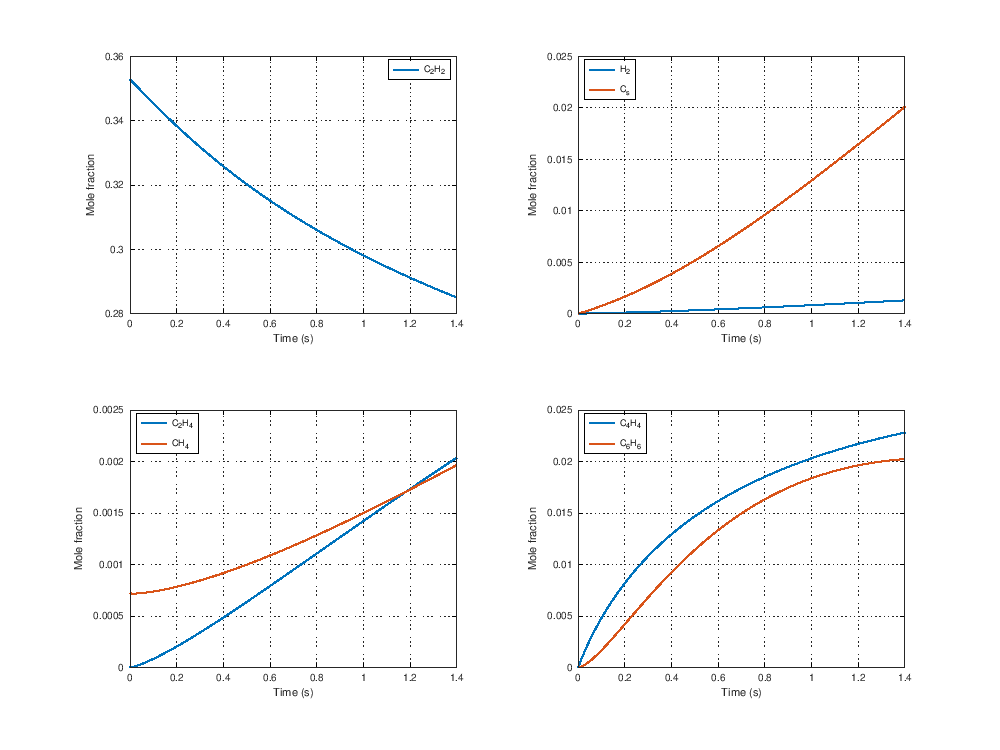

In [4]:
%plot inline -w 1000
h = IntegKinetics(5000.0, 1073.0, 0.36, 1.4, 100);

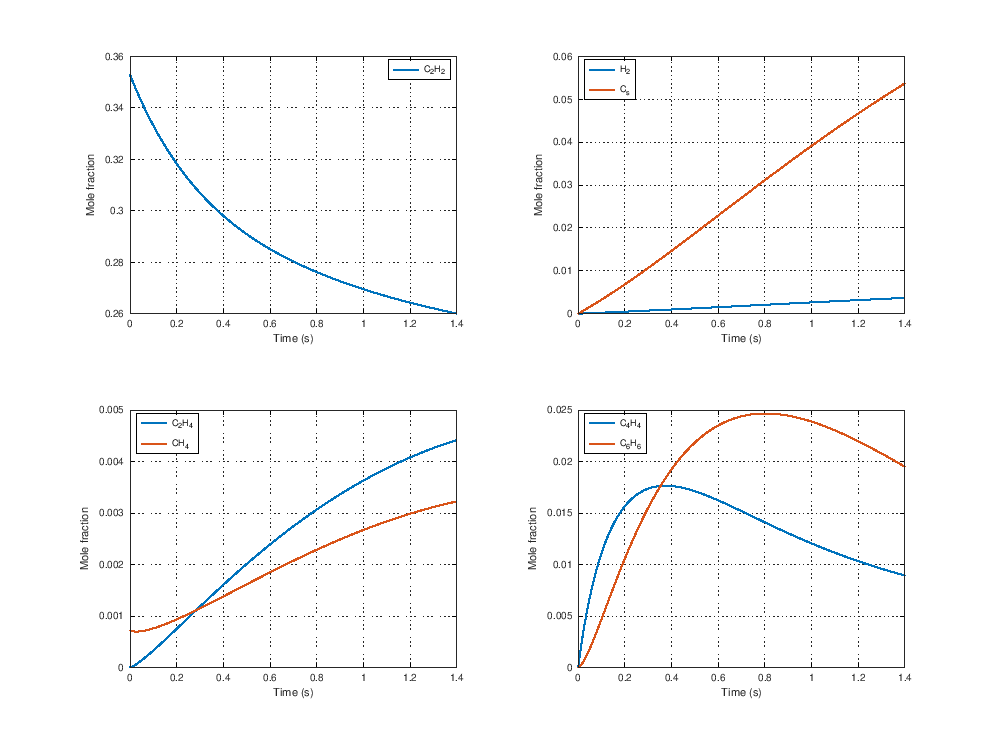

In [5]:
%plot inline -w 1000
h = IntegKinetics(5000.0, 1173.0, 0.36, 1.4, 100);

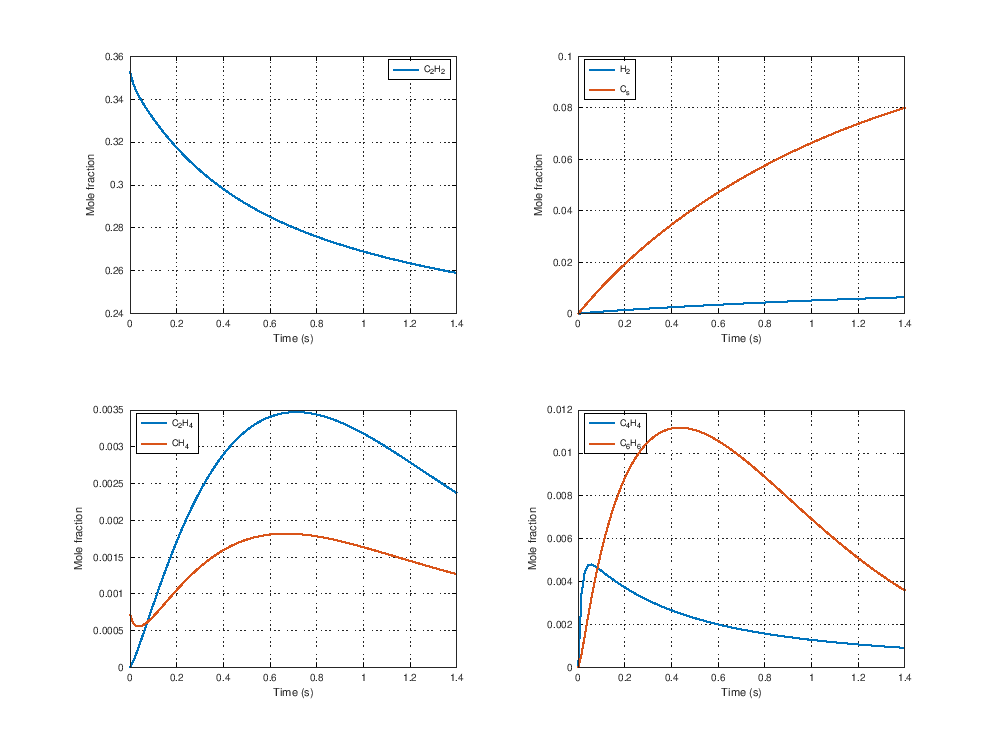

In [6]:
%plot inline -w 1000
h = IntegKinetics(5000.0, 1273.0, 0.36, 1.4, 100);

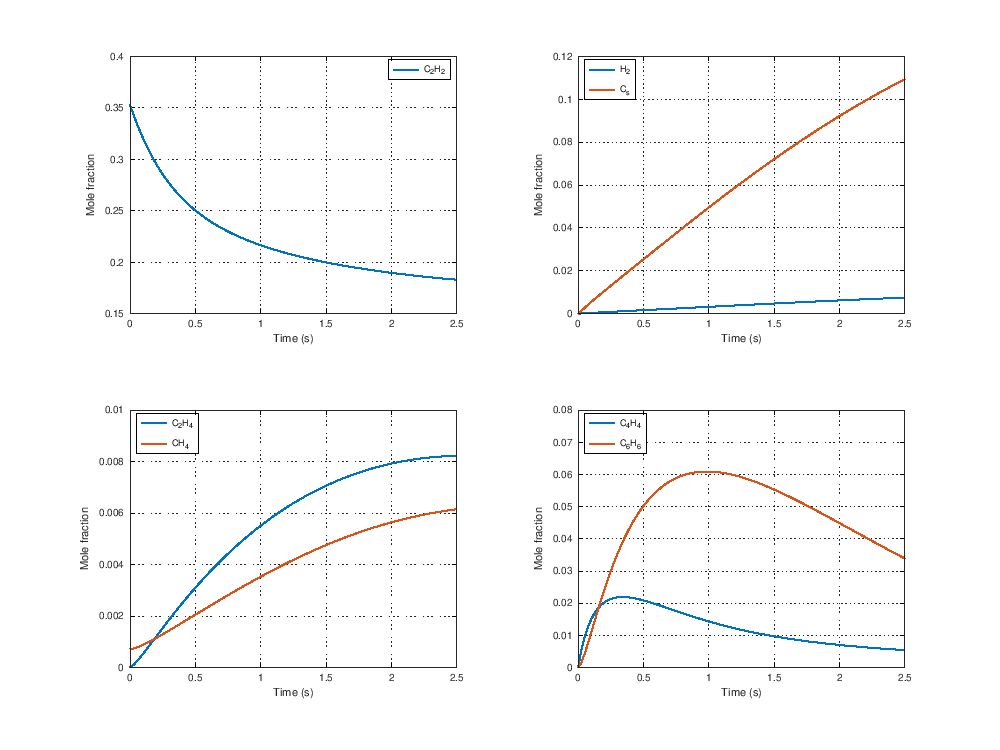

In [7]:
%plot inline -w 1000
h = IntegKinetics(10000.0, 1173.0, 0.36, 2.5, 100);